# CSE-676 Programming Assignment-1 [100pts]

## Task-1 [20pts]

### Modular Implementation of a Neural Network for Binary Classification
Implement a modular Two Layer Neural Network to classify datapoints from the given dataset.

#### Dataset Source:
https://scikit-learn.org/0.16/modules/generated/sklearn.datasets.make_moons.html

#### References:
https://cs231n.github.io/optimization-2/


In [570]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [571]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Step-1: Initialize Parameters such as Weights and Biases

In [572]:
def initialize_parameters(n_x, n_h, n_y):
    # ====================== YOUR CODE HERE ======================
    np.random.seed(369)

    # Initialize weights w/ very small random values and biases with ones
    layer_one_weights = np.random.randn(n_h, n_x) * 0.005
    layer_two_weights = np.random.randn(n_y, n_h) * 0.005

    layer_one_bias = np.ones((n_h, 1)) # bias of 1
    layer_two_bias = np.ones((n_y, 1))

    params = layer_one_weights, layer_one_bias, layer_two_weights, layer_two_bias
    return params
    # ============================================================

#### Step-2: Define Sigmoid, ReLU & ReLU Functions

In [573]:
def sigmoid(Z):
    # ====================== YOUR CODE HERE ======================
    # useful for binary (2-class) classification
    return 1 / 1 / (1 + np.exp(-Z))
    # ============================================================

def relu(Z):
    # ====================== YOUR CODE HERE ======================
    return np.maximum(0,Z)
    # ============================================================
    
def relu_derivative(Z):
    # ====================== YOUR CODE HERE ======================
    return np.where(Z > 0, 1, 0)
    # ============================================================

#### Forward Propagation

In [574]:
def forward_propagation(X, params):
    # ====================== YOUR CODE HERE ======================

    # access initialized params
    weights_1, biases_1, weights_2, biases_2 = params

    # FFN pass 1 z = Wx+b
    Z1 = np.dot(weights_1, X.T) + biases_1

    # Activation function on hidden layer
    A1 = relu(Z1)

    # Second layer - Linear -> Sigmoid
    Z2 = np.dot(weights_2, A1) + biases_2   # Shape: (n_y, m)
    A2 = sigmoid(Z2)           # Shape: (n_y, m)
    # ============================================================
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache
    

#### Step-3: Define Loss Function

In [575]:
def compute_loss(A2, Y):
    # ====================== YOUR CODE HERE ======================

    # SOURCE REFERENCED: https://www.geeksforgeeks.org/binary-cross-entropy-log-loss-for-binary-classification/

    n = Y.shape[0]

    # Binary cross-entropy loss
    loss = -1/n * np.sum(Y * np.log(A2.T + 1e-8) + (1 - Y) * np.log(1 - (A2.T + 1e-8)))

    # ============================================================
    return np.squeeze(loss)


#### Step-4: Compute Gradients at each layer

In [576]:
def backward_propagation(X, Y, params, cache):
    # ====================== YOUR CODE HERE ======================

    m = X.shape[0] # of inputs

    # access initialized params
    weights_1, biases_1, weights_2, biases_2 = params

    # Retrieve activations from cache
    A1, A2, Z1 = cache["A1"], cache["A2"], cache["Z1"]

    # Backprop from output --- SOURCE REFERENCED: https://numpy.org/doc/2.1/reference/generated/numpy.sum.html
    # Derivative of the loss w.r.t. output layer (error term for output)
    dZ2 = A2 - Y.T
    # Gradient of the weights for the second layer
    dW2 = 1/m * np.dot(dZ2, A1.T)
    # Gradient of the bias for the second layer
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)

    # Backprop from hidden layer
    # Gradient w.r.t. A1 (hidden layer activation)
    dA1 = np.dot(weights_2.T, dZ2)
    # Derivative of the loss w.r.t. hidden layer pre-activation
    dZ1 = dA1 * relu_derivative(Z1)
    # Gradient of the weights for the first layer
    dW1 = 1/m * np.dot(dZ1, X)
    # Gradient of the bias for the first layer
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)

    # ============================================================
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads

#### Step-5: Define Weight Update step

In [577]:
def update_parameters(params, grads, learning_rate):
    # ====================== YOUR CODE HERE ======================

    # access initialized params
    weights_1, biases_1, weights_2, biases_2 = params

    # Retrieve gradients
    dW1, db1, dW2, db2 = grads["dW1"], grads["db1"], grads["dW2"], grads["db2"]

    # iteratively improve params w G.D.
    weights_1, biases_1 = weights_1 - learning_rate * dW1, biases_1 - learning_rate * db1
    weights_2, biases_2 = weights_2 - learning_rate * dW2, biases_2 - learning_rate * db2

    params = weights_1, biases_1, weights_2, biases_2
        # ============================================================
    return params

In [578]:
lr = 0.1
num_epochs = 10000

def train(X, Y, n_h, learning_rate=lr, num_iterations=num_epochs):
    n_x, n_y = X.shape[1], 1
    print(n_x, n_y)
    params = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(num_iterations):
        A2, cache = forward_propagation(X, params)
        loss = compute_loss(A2, Y)
        grads = backward_propagation(X, Y, params, cache)
        params = update_parameters(params, grads, learning_rate)
        
        if i % 1000 == 0:
            print(f"Iteration {i}: Loss = {loss:.4f}")
    return params

In [579]:
def predict(X, params):
    A2, _ = forward_propagation(X, params)
    return (A2 > 0.5).astype(int).T

In [580]:
params = train(X_train, y_train, n_h=4, learning_rate=0.1, num_iterations=10000)

train_preds = predict(X_train, params)
test_preds = predict(X_test, params)
train_acc = np.mean(train_preds == y_train) * 100
test_acc = np.mean(test_preds == y_test) * 100
print(f"Train Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

2 1
Iteration 0: Loss = 0.8296
Iteration 1000: Loss = 0.2847
Iteration 2000: Loss = 0.2815
Iteration 3000: Loss = 0.2805
Iteration 4000: Loss = 0.2801
Iteration 5000: Loss = 0.2798
Iteration 6000: Loss = 0.2797
Iteration 7000: Loss = 0.2796
Iteration 8000: Loss = 0.2795
Iteration 9000: Loss = 0.2794
Train Accuracy: 85.75%
Test Accuracy: 86.00%


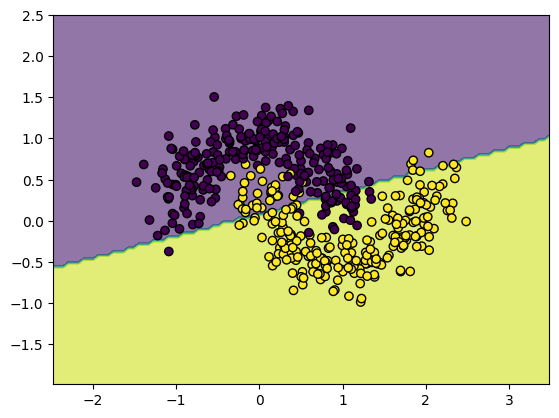

In [581]:
def plot_decision_boundary(X, y, params):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    predictions = predict(grid_points, params).reshape(xx.shape)
    plt.contourf(xx, yy, predictions, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolors='k')
    plt.show()
plot_decision_boundary(X, y, params)

## Task-2 [15pts]

### XOR Function

This Task helps to explores how to train a Feedforward Neural Network (FFN) to approximate mathematical functions. 
#### Objective:
- Understand and generate data for different functions
- Design a simple NN using PyTorch
- rain model to accurately predict required outputs.
- Understand the use of Linear & Non-Linear Activation Functions.

#### XOR Truth Table

XOR (exclusive OR) function, a fundamental problem in neural networks that demonstrates the need for non-linear activation functions.

$
\begin{array}{|c|c|c|}
\hline
A & B & A \oplus B \\
\hline
F & F & F \\
F & T & T \\
T & F & T \\
T & T & F \\
\hline
\end{array}
$


In [582]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

#### Step-1 Generate XOR data

In [583]:
def generate_xor_data():
    # XOR in/out training
    X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
    y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

    return X, y
    # ============================================================

#### Step-2: Implement XOR Model

In [584]:
class XORModel(nn.Module):
    def __init__(self):
        super(XORModel, self).__init__()
        # ====================== YOUR CODE HERE ======================
        # XOR not linear or a combination of linear so we need a hidden layer

        #input and hidden layer
        self.layer1 = nn.Linear(2, 4)
        self.layer2 = nn.Linear(4, 1)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        # ============================================================

    def forward(self, x):
        # ====================== YOUR CODE HERE ======================
        # FeedForward
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        # ============================================================
        return x

#### Step-3: Implement Training steps

In [585]:
num_epochs =  5000 # Number of Epochs
learning_rate = 0.1 # Learning rate

def train_model(model, X, y, epochs=num_epochs, lr=learning_rate):
    # ====================== YOUR CODE HERE ======================

    # SOURCE: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
    # SOURCE: https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.SGD(model.parameters(), lr=lr)  # Stochastic Gradient Descent
    # ============================================================

    losses = []
    for epoch in range(epochs):
        # ====================== YOUR CODE HERE =====================

        # forward
        y_hat = model(X)
        loss = criterion(y_hat, y)

        #backward
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients for backprop
        optimizer.step()       # Update model params

        # Store loss and print
        losses.append(loss.item())
        if epoch % 500 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}')

        # ============================================================

    return losses

#### Step-4: Define model to test predictions from model

In [586]:
def test_model(model, X):
    # ====================== YOUR CODE HERE ======================
    model.eval()

    # Forward pass
    with torch.no_grad():  # No need to track gradients
        predictions = torch.round(model(X))  # Rround up/down for binary predictions

    return predictions
    # ============================================================

In [587]:
X, y = generate_xor_data()
model = XORModel()
losses = train_model(model, X, y)

Epoch 0/5000, Loss: 0.7557
Epoch 500/5000, Loss: 0.3077
Epoch 1000/5000, Loss: 0.0648
Epoch 1500/5000, Loss: 0.0292
Epoch 2000/5000, Loss: 0.0179
Epoch 2500/5000, Loss: 0.0127
Epoch 3000/5000, Loss: 0.0097
Epoch 3500/5000, Loss: 0.0078
Epoch 4000/5000, Loss: 0.0065
Epoch 4500/5000, Loss: 0.0056


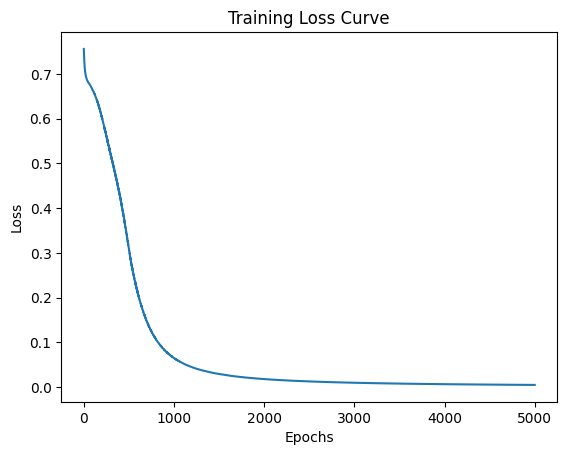

In [588]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [589]:
predictions = test_model(model, X)
print("Predictions:\n", predictions.numpy())

Predictions:
 [[0.]
 [1.]
 [1.]
 [0.]]


## Task-3 [15pts]

### Weierstrass function

$f(x) = \sum_{n=0}^{\infty} a^n \cos(b^n \pi x)$ 
- $0<a<1$ 
- $b$ is a positive odd integer. 
- $ab>1+\frac{3}{2}.\pi$ 


#### Step-1

In [590]:
a = 0.1 # value of a
def weierstrass(x, a=a, b=7, n=20):
    # ====================== YOUR CODE HERE ======================
    accumulator = 0
    for i in range(n):
        accumulator += a**i * np.cos(b**i * np.pi * x)
    return accumulator
    # ============================================================

#### Step-2

In [591]:

# ====================== YOUR CODE HERE ======================
X = np.linspace(-10, 10, 963, dtype=np.float32).reshape(-1, 1)
y = np.vectorize(weierstrass)(X).astype(np.float32).reshape(-1,1)
# ============================================================

X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)



#### Step-3

In [592]:
class FFN(nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        # ====================== YOUR CODE HERE ======================
        # FFn to approx weier
        self.layer1 = nn.Linear(1,4)   # input
        self.layer2 = nn.Linear(4, 16) # hiddnes
        self.layer3 = nn.Linear(16, 32)
        self.layer4 = nn.Linear(32, 64)
        self.layer5 = nn.Linear(64, 128)
        self.layer6 = nn.Linear(128, 256)


        # Activation function (avoids exploding/vanishing gradient(s))
        self.relu = nn.ReLU()
        # ============================================================

    def forward(self, x):
        # ====================== YOUR CODE HERE ======================
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.relu(x)
        x = self.layer4(x)
        x = self.relu(x)
        x = self.layer5(x)
        x = self.relu(x)
        x = self.relu(x)

        return x
        # ============================================================



#### Step-4

In [593]:
def train_ffn(model, X, y, epochs=5000, lr=0.001):
    # ====================== YOUR CODE HERE ======================

    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error Loss
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer

    losses = []
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store loss
        losses.append(loss.item())

        # Print progress
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.6f}')
    # ============================================================
    return losses

In [594]:
model = FFN()
losses = train_ffn(model, X_tensor, y_tensor)

Epoch 0, Loss: 0.510500
Epoch 500, Loss: 0.461554
Epoch 1000, Loss: 0.452906
Epoch 1500, Loss: 0.449646
Epoch 2000, Loss: 0.448690
Epoch 2500, Loss: 0.448431
Epoch 3000, Loss: 0.448388
Epoch 3500, Loss: 0.448355
Epoch 4000, Loss: 0.448348
Epoch 4500, Loss: 0.448344


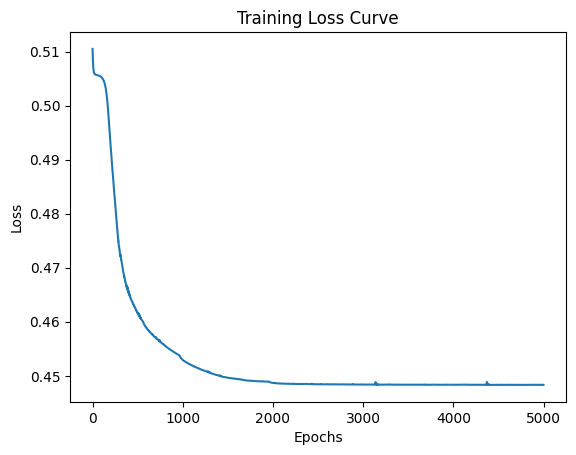

In [595]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

#### Step-5

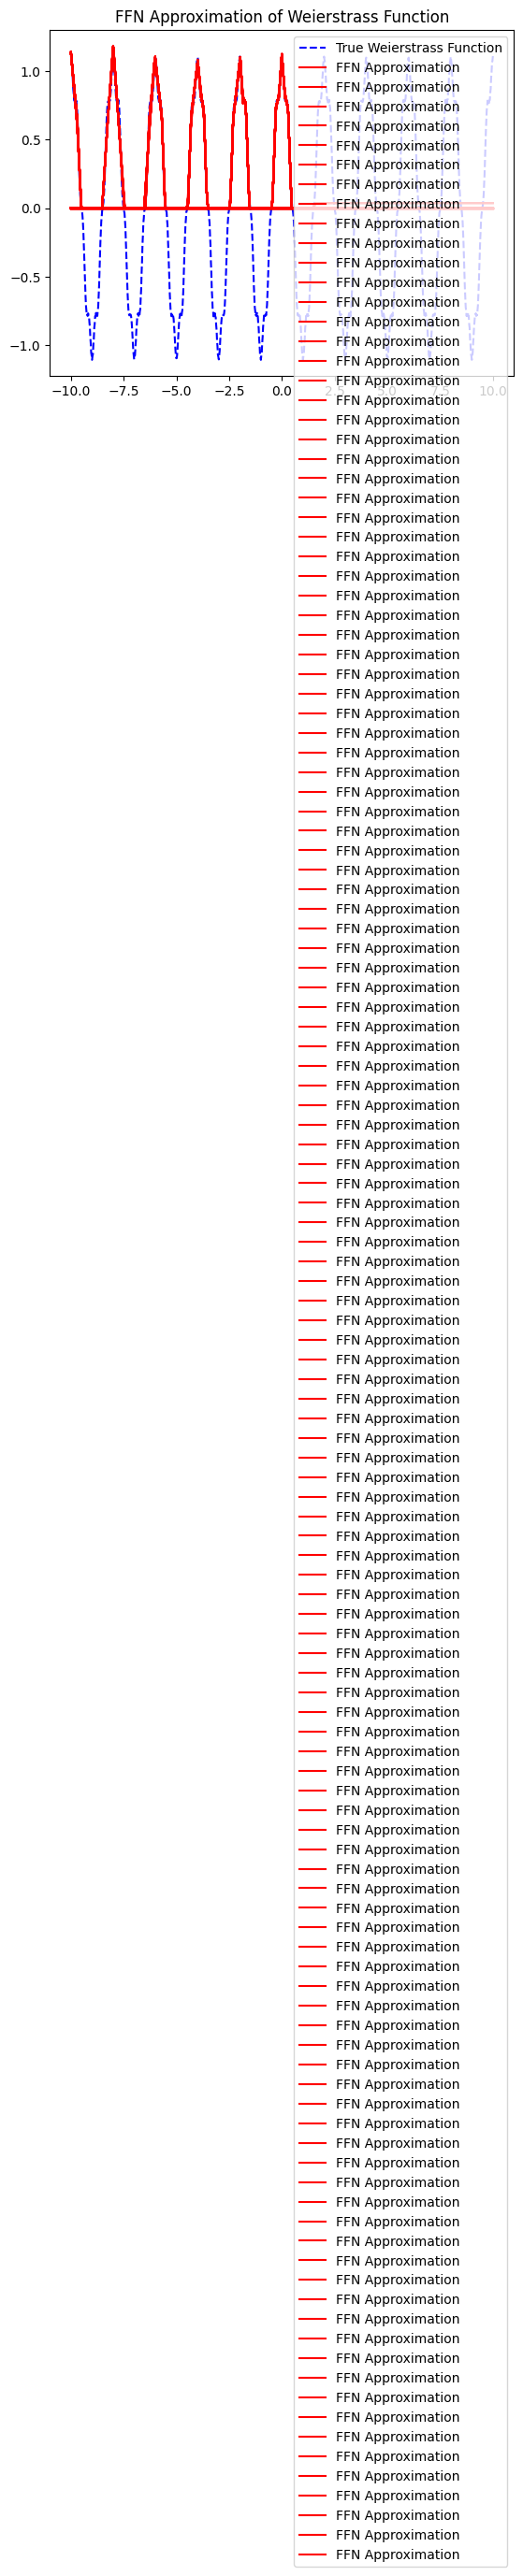

In [596]:

with torch.no_grad():
    # ====================== YOUR CODE HERE ======================
    # predictions from trained model
        y_pred = model(X_tensor).numpy()
    # ============================================================
plt.plot(X, y, label='True Weierstrass Function', linestyle='dashed', color='blue')
plt.plot(X, y_pred, label='FFN Approximation', color='red')
plt.legend()
plt.title('FFN Approximation of Weierstrass Function')
plt.show()

## Task-4 [50pts]

In [597]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

The goal of this task is to understand the impact of various hyperparameters on the performance of a deep learning model trained on the IRiS dataset. You will conduct experiments by modifying activation functions, learning rate, regularization techniques, and network depth. You will then analyze the results using plots.

**4.a)** Change the Activation Functions and Plot Accuracy Curves
- ReLU
- Sigmoid
- Tanh
- Leaky ReLU
- Swish
- ELU

**4.b)** Change the Learning Rate and Plot Accuracy Curves

**4.c)** Change Regularization and Compare Results 
- No regularization (baseline model)
- L1 Regularization
- L2 Regularization (Weight Decay)
- Dropout (50% probability for some layers)

**4.d)** Add Layers and Observe Accuracy Changes.
- Baseline model: 3 hidden layers (256 → 128 → 64)
- Deeper model: 5 hidden layers (512 → 256 → 128 → 64 → 32)
- Shallow model: 2 hidden layers (128 → 64)

In [598]:
from sklearn import datasets
import pandas as pd

iris = datasets.load_iris()

In [599]:
activation_functions = {
    "ReLU": nn.ReLU(),
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh(),
    "LeakyReLU": nn.LeakyReLU(),
    "ELU": nn.ELU()
}

 4a) activation functions 
Testing ReLU...
Epoch 0, Loss: 1.1034, Accuracy: 0.9333
Epoch 50, Loss: 0.0035, Accuracy: 0.9667
Epoch 100, Loss: 0.0001, Accuracy: 0.9667
Epoch 150, Loss: 0.0001, Accuracy: 0.9667
Epoch 200, Loss: 0.0000, Accuracy: 0.9667
Epoch 250, Loss: 0.0000, Accuracy: 0.9667
Testing Sigmoid...
Epoch 0, Loss: 1.1611, Accuracy: 0.2333
Epoch 50, Loss: 0.0508, Accuracy: 1.0000
Epoch 100, Loss: 0.0439, Accuracy: 0.9667
Epoch 150, Loss: 0.0404, Accuracy: 0.9667
Epoch 200, Loss: 0.0348, Accuracy: 0.9667
Epoch 250, Loss: 0.0243, Accuracy: 1.0000
Testing Tanh...
Epoch 0, Loss: 1.0621, Accuracy: 0.8667
Epoch 50, Loss: 0.0190, Accuracy: 1.0000
Epoch 100, Loss: 0.0003, Accuracy: 1.0000
Epoch 150, Loss: 0.0002, Accuracy: 1.0000
Epoch 200, Loss: 0.0001, Accuracy: 1.0000
Epoch 250, Loss: 0.0001, Accuracy: 1.0000
Testing LeakyReLU...
Epoch 0, Loss: 1.1040, Accuracy: 0.8333
Epoch 50, Loss: 0.0066, Accuracy: 0.9667
Epoch 100, Loss: 0.0001, Accuracy: 0.9667
Epoch 150, Loss: 0.0000, Accura

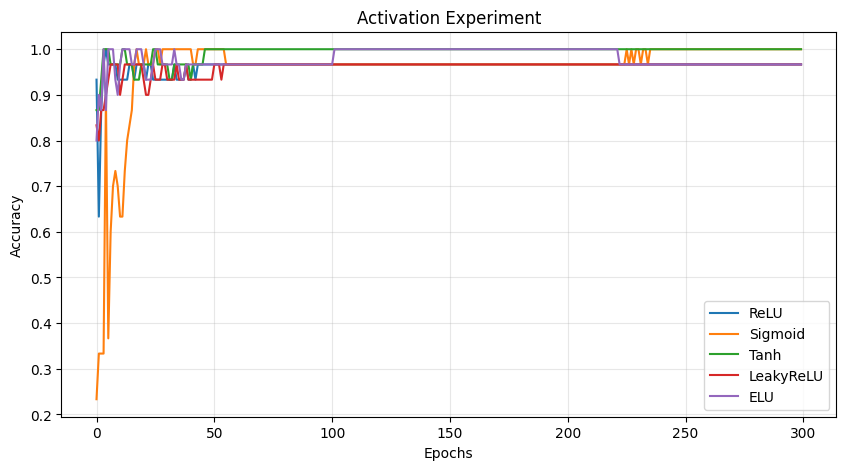

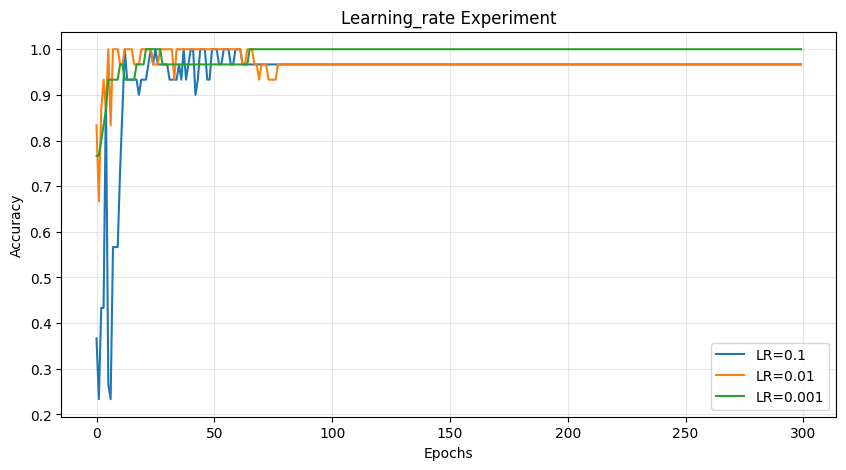

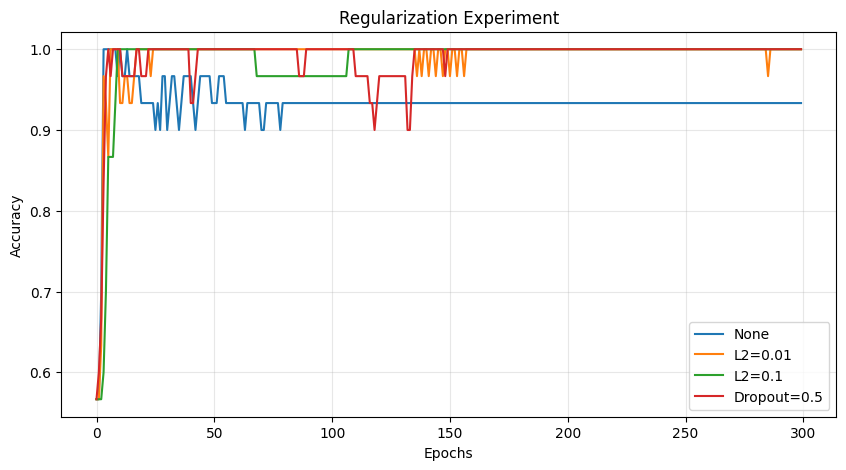

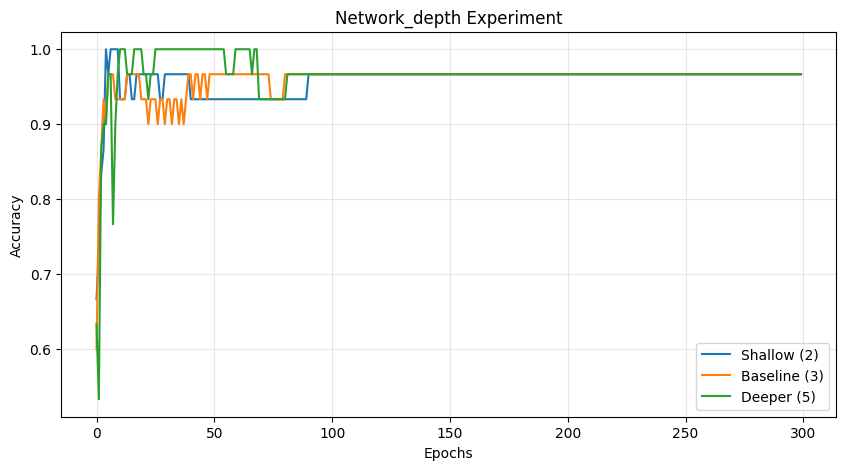

 top performing models 
Best activation: ReLU (Accuracy: 1.0000)
Best learning_rate: LR=0.1 (Accuracy: 1.0000)
Best regularization: None (Accuracy: 1.0000)
Best network_depth: Shallow (2) (Accuracy: 1.0000)


In [600]:
from sklearn.datasets import load_iris

iris = datasets.load_iris()
X = torch.tensor(iris.data, dtype=torch.float32)
y = torch.tensor(iris.target, dtype=torch.long)
X = (X - X.mean(0)) / X.std(0)  # Normalize

# Split dataset (80% train, 20% test)
train_size = int(0.8 * len(X))
idx = torch.randperm(len(X))
X_train, y_train = X[idx[:train_size]], y[idx[:train_size]]
X_test, y_test = X[idx[train_size:]], y[idx[train_size:]]

# Base model class with configurable architecture
class IrisModel(nn.Module):
    def __init__(self, activation=nn.ReLU(), layers=None, dropout=None):
        super().__init__()
        self.activation = activation
        self.dropout = dropout

        # Configure layers
        if layers is None:
            # Default: 3 hidden layers (4→256→128→64→3)
            layers = [4, 256, 128, 64, 3]

        # Create network
        self.net = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x):
        for i, layer in enumerate(self.net):
            x = layer(x)
            # Apply activation and dropout to all but the last layer
            if i < len(self.net) - 1:
                x = self.activation(x)
                if self.dropout is not None:
                    x = self.dropout(x)
        return x

# Unified training function
def train_and_evaluate(model, epochs=300, lr=0.01, weight_decay=0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    losses, accuracies = [], []
    for epoch in range(epochs):
        # Train
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Evaluate
        model.eval()
        with torch.no_grad():
            acc = (torch.argmax(model(X_test), 1) == y_test).float().mean().item()
            accuracies.append(acc)

        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')

    return losses, accuracies

# Run experiments and store results
def run_experiments():
    results = {
        "activation": {},
        "learning_rate": {},
        "regularization": {},
        "network_depth": {}
    }

    # 4.a) Activation Functions
    print(" 4a) activation functions ")
    for name, fn in activation_functions.items():
        print(f"Testing {name}...")
        model = IrisModel(activation=fn)
        results["activation"][name] = train_and_evaluate(model)

    # 4.b) Learning Rates
    print(" 4b) learning rates ")
    for lr in [0.1, 0.01, 0.001]:
        print(f"Testing LR={lr}...")
        model = IrisModel()
        results["learning_rate"][f"LR={lr}"] = train_and_evaluate(model, lr=lr)

    # 4.c) Regularization
    print(" 4c) regularization ")
    # No regularization (baseline)
    model = IrisModel()
    results["regularization"]["None"] = train_and_evaluate(model)

    # L2 regularization
    for wd in [0.01, 0.1]:
        model = IrisModel()
        results["regularization"][f"L2={wd}"] = train_and_evaluate(model, weight_decay=wd)

    # Dropout
    model = IrisModel(dropout=nn.Dropout(0.5))
    results["regularization"]["Dropout=0.5"] = train_and_evaluate(model)

    # 4.d) Network Depth
    print(" 4d) network depths ")
    # Shallow (2 hidden layers)
    model = IrisModel(layers=[4, 128, 64, 3])
    results["network_depth"]["Shallow (2)"] = train_and_evaluate(model)

    # Baseline (3 hidden layers)
    model = IrisModel()  # Default is 3 hidden layers
    results["network_depth"]["Baseline (3)"] = train_and_evaluate(model)

    # Deeper (5 hidden layers)
    model = IrisModel(layers=[4, 512, 256, 128, 64, 32, 3])
    results["network_depth"]["Deeper (5)"] = train_and_evaluate(model)

    return results

# Plot results
def plot_all_results(all_results):
    for exp_name, exp_results in all_results.items():
        plt.figure(figsize=(10, 5))
        for name, (_, accuracies) in exp_results.items():
            plt.plot(accuracies, label=name)
        plt.title(f"{exp_name.capitalize()} Experiment")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Run all experiments
results = run_experiments()

# Plot results
plot_all_results(results)

# Print best models
print(" top performing models ")
for exp_name, exp_results in results.items():
    best_config = max(exp_results.items(), key=lambda x: max(x[1][1]))
    print(f"Best {exp_name}: {best_config[0]} (Accuracy: {max(best_config[1][1]):.4f})")


### Academic Integrity

Academic integrity is critical to the learning process. It is your responsibility as a student to complete your work in an honest fashion, upholding the expectations your individual instructors have for you in this regard. The ultimate goal is to ensure that you learn the content in your courses in accordance with UB’s academic integrity principles regardless of whether instruction is in-person or remote. Thank you for upholding your own personal integrity and ensuring UB’s tradition of academic excellence. For further details, please visit https://www.buffalo.edu/academic-integrity.html.